저번주 토요일 DDQN 발표 준비를 하면서, DQN 조차 어려워 쩔쩔매는 내 모습을 보면서, 코드를 꼭 한 줄 한 줄 공부해봐야 생각했다. 퍼실 이정우 님이 직접 구현한 코드를 올려주셔서 공부해보려고 한다. 우선 DQN부터 해보겠다.

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.distributions import Normal
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import deque
import random

내 기억 상으로 구현해야 할 것들이 Q 네트워크랑 replay memory가 있다. 우선 Q 네트워크를 구현해보자. 클래스로 만들겠다

In [2]:
class Q(nn.Module):
    def __init__(self, state_space, action_space):
        super(Q, self).__init__()
        self.fc1 = nn.Linear(state_space, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_space)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        Q_values = self.fc3(x)
        
        return Q_values

ε-greedy도 정의해야 한다. DQN 정도까지 왔으면 다들 이게 뭔지 알것이다. 점점 greedy를 줄인다<br>
정해준 ε 값보다 작은 random한 값이 나오면 action을 random하게 선택하고, 큰 값이 나오면 Q_values 중에 가장 큰 값을 선택하게 한다.

In [15]:
def e_greedy(Q_values, action_space, epsilon):
    if np.random.rand() <= epsilon:
        action = random.randrange(action_space)
        return action
    else:
        return Q_values.argmax().item()

train 함수도 만들어보자. DQN에서는 mini-batch도 필요하다

In [16]:
def train(Q_func_net, Q_target_net, random_mini_batch):
    
    gamma = 0.99
    
    mini_batch = np.array(random_mini_batch)
    obs = np.vstack(mini_batch[:, 0])
    actions = list(mini_batch[:, 1])
    rewards = list(mini_batch[:, 2])
    next_obs = np.vstack(mini_batch[:,3])
    masks = list(mini_batch[:, 4])
    
    #이들을 tensor로 변환해줘야 한다.
    obs = torch.Tensor(obs)
    actions = torch.LongTensor(actions).unsqueeze(1)
    rewards = torch.Tensor(rewards)
    next_obs = torch.Tensor(next_obs)
    masks = torch.Tensor(masks)
    
    # Q-value를 얻어보자
    Q_values = Q_func_net(obs)
    q_value = Q_values.gather(1, actions).view(-1)
    # 각 value로 선택된 action들의 q value를 얻어온다.
    
    # max함수를 사용하면 [0]에는 value 값이들어 가 있고 [1]에는 index값이 들어가 있다.
    target_q_value = Q_target_net(torch.Tensor(next_obs)).max(1)[0]
    
    Y = rewards + masks*gamma*target_q_value
    
    #loss
    MSE = torch.nn.MSELoss()
    # target은 단순히 주기적으로 업데이트해 네트워크를 유지시키므로, parameter가 미분되선 안된다. 그래서 detach() 해준다.
    loss = MSE(q_value, Y.detach())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

하이퍼 파라미터들은 퍼실 님이 한 자료 그대로 가져왔다

In [17]:
initial_exploration = 2000 ## 10000개의 memory가 쌓이고 나서 학습 시작!
learning_rate = 0.0005
epsilon = 1 ## epsilon 1 부터 줄어들어감.
epsilon_decay = 0.00001 ## episilon 감쇠 값.
replay_buffer = deque(maxlen=100000) ## 덱으로 편하게 replay_buffer의 max 값을 정해줍니다. 가득 차게 되면 알아서 FIFO 형태로 데이터 저장됨.
batch_size = 32 ## data batch size
print_interval = 500 ## 몇 episode 마다 출력할건지.

update_target = 2000 ## 몇 step 마다 target network를 업데이트 할지.
maximum_steps = 500 ## infinite task라 일정 시점에서 게임을 종료 시켜줘야함.
episode = 1000000 # episode 정해주기.

action_space = 2
state_space = 4

이제 환경을 만들어 봅시다~ 우리는 **cartpole**을 사용한다.

아래에서 부족한 개념들
- `state_dict` : 각 계층을 매개변수 텐서로 매핑되는 python 사전(dict) 갹체. 학습 가능한 매개변수를 갖는 계층 및 등록된 버퍼들만이 `state_dict`에 항목을 가진다.(`torch.optim` 포함)<br>
추론을 위해 모델을 저장할 때는 학습된 모델의 학습된 매개변수만 저자하면 된다. `torch.save()`를 사용하여 모델의 state_dict를 저장하는 것이 나중에 모델을 사용할 때 가장 유연하게 사용할 수 있다. 

- `load_state_dict()` 함수에는 저장된 객체가 경로가 아닌, **사전 객체를 전달해야** 한다. 객체 자체를 전달해야 된다는 말인 것 같다. 계속 파이토치를 접해보면서 몸에 익히자!

<ipython-input-16-a8e396111914>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mini_batch = np.array(random_mini_batch)


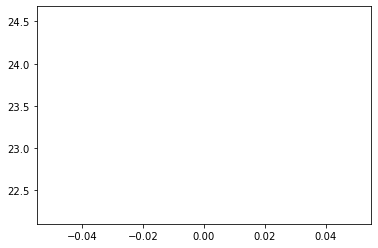

episode:  500  step:  11696  epsilon:  0.9030400000004413  score:  23.392


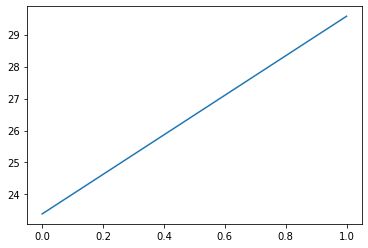

episode:  1000  step:  26483  epsilon:  0.7551700000011142  score:  29.574


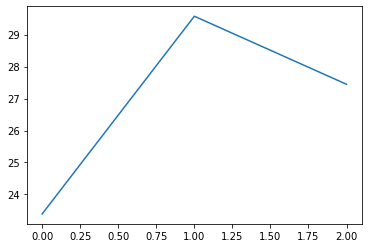

episode:  1500  step:  40206  epsilon:  0.6179400000017388  score:  27.446


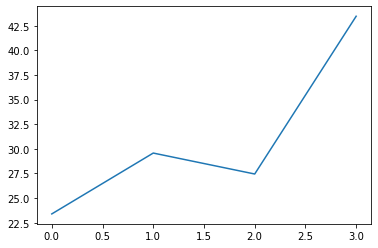

episode:  2000  step:  61942  epsilon:  0.4005800000021761  score:  43.472


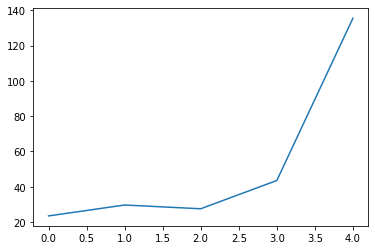

episode:  2500  step:  129676  epsilon:  0.05  score:  135.468


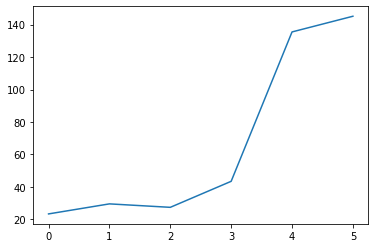

episode:  3000  step:  202241  epsilon:  0.05  score:  145.13


In [ ]:
env = gym.make('CartPole-v1')

Q_function_net = Q(state_space, action_space)
Q_target_net = Q(state_space, action_space)

optimizer = optim.Adam(Q_function_net.parameters(), lr = learning_rate)
Q_target_net.load_state_dict(Q_function_net.state_dict())

step = 0
score = 0
show_score = []

for epi in range(episode):
    obs = env.reset() 
    for i in range(maximum_steps):
        Q_values = Q_function_net(torch.Tensor(obs))
        action = e_greedy(Q_values, action_space, epsilon)
        next_obs, reward, done, _ = env.step(action)
        # next_s, reward, done, info
        
        # 게임이 종료됐으면, done이 1이면 mask = 0 (생존유무 표시용)
        mask = 0 if done else 1
        
        replay_buffer.append((obs, action, reward, next_obs, mask))
        obs = next_obs
        score += reward
        step += 1
        
        if step > initial_exploration:
            epsilon -= epsilon_decay
            epsilon = max(epsilon, 0.05) # 가끔 새로운 exploration을 위해
            random_mini_batch = random.sample(replay_buffer, batch_size)
            train(Q_function_net, Q_target_net, random_mini_batch)
            
            if step % update_target == 0 and step>update_target:
                Q_target_net.load_state_dict(Q_function_net.state_dict())
                
        if done:
                break
        
    if epi % print_interval == 0 and epi!= 0:
        show_score.append(score/print_interval)
        plt.plot(show_score)
        plt.show()
        print('episode: ',epi,' step: ',step,' epsilon: ',epsilon,' score: ',score/print_interval)
        score = 0
env.close()        